# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [2]:
storage = paths.AnalysisStorage("mstis.nc")

In [3]:
mstis = storage.networks.load(0)

In [4]:
[[storage.idx(samp.trajectory) for samp in ssamp] for ssamp in storage.samplesets]

[[0, 1, 2, 3, 4, 5, 3, 6, 7, 8, 9, 10, 11],
 [0, 3, 4, 5, 3, 6, 7, 8, 9, 10, 11, 2, 1],
 [0, 3, 4, 5, 3, 6, 7, 8, 9, 10, 11, 2, 12],
 [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13],
 [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13],
 [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13],
 [0, 3, 4, 5, 6, 7, 8, 10, 11, 2, 12, 13, 15],
 [0, 3, 4, 5, 6, 7, 8, 10, 11, 2, 12, 13, 15],
 [0, 3, 4, 6, 7, 8, 10, 11, 2, 12, 13, 5, 15],
 [0, 3, 4, 6, 7, 8, 10, 2, 12, 13, 5, 15, 17],
 [0, 3, 4, 6, 7, 8, 10, 2, 12, 13, 5, 15, 17],
 [0, 3, 4, 6, 7, 8, 10, 2, 12, 13, 5, 15, 17],
 [0, 3, 4, 6, 7, 8, 10, 2, 13, 5, 15, 17, 19],
 [0, 3, 4, 6, 7, 8, 2, 13, 5, 15, 17, 19, 20],
 [0, 3, 4, 6, 7, 8, 2, 13, 5, 15, 17, 19, 20],
 [0, 3, 4, 6, 7, 8, 2, 13, 5, 15, 17, 19, 20],
 [0, 3, 6, 7, 8, 2, 13, 5, 15, 17, 19, 20, 22],
 [0, 3, 6, 7, 8, 2, 13, 15, 17, 19, 20, 22, 23],
 [0, 3, 6, 7, 8, 2, 13, 17, 19, 20, 22, 15, 23],
 [0, 3, 6, 7, 8, 13, 17, 19, 20, 22, 15, 23, 24],
 [3, 6, 7, 8, 13, 17, 19, 20, 22, 15, 23, 24, 25],
 [3, 6, 7, 8

## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [5]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [6]:
%%time
mstis.rate_matrix(storage)

CPU times: user 2.88 s, sys: 133 ms, total: 3.01 s
Wall time: 2.92 s


,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,2.75792e-05,8.93674e-05
"{x|opB(x) in [0.0, 0.04]}",0.000782454,NaN,0
"{x|opC(x) in [0.0, 0.04]}",0.000338298,0.0014027,NaN


The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [7]:
stateA = storage.volumes.find_first("A")
stateB = storage.volumes.find_first("B")
stateC = storage.volumes.find_first("C")

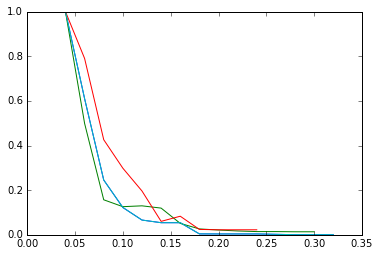

In [8]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

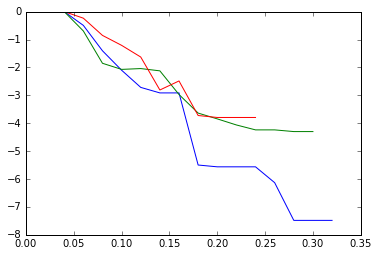

In [9]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on 

In [10]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.set_value(state_pair[0], state_pair[1], transition._flux)

flux_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.038961,0.038961
"{x|opB(x) in [0.0, 0.04]}",0.0395034,NaN,0.0395034
"{x|opC(x) in [0.0, 0.04]}",0.0968523,0.0968523,NaN


### Conditional transition probability

In [11]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.set_value(state_pair[0], state_pair[1], transition.ctp[transition.ensembles[-1]])    

outer_ctp_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.173045,0.560732
"{x|opB(x) in [0.0, 0.04]}",0.237937,NaN,0
"{x|opC(x) in [0.0, 0.04]}",0.0682196,0.282862,NaN


In [12]:
ctp_by_interface = pd.DataFrame(index=mstis.transitions)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    for ensemble_i in range(len(transition.ensembles)):
        ctp_by_interface.set_value(
            state_pair, ensemble_i,
            transition.conditional_transition_probability(
                storage,
                transition.ensembles[ensemble_i]
        ))
    
    
ctp_by_interface  

,0,1,2
"({x|opA(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.018303,0.113145,0.173045
"({x|opB(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.056572,0.016639,0.237937
"({x|opC(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.000000,0.000000,0.068220
"({x|opA(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.000000,0.076539,0.560732
"({x|opB(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.000000,0.000000,0.000000
"({x|opC(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.000000,0.064892,0.282862


## Path ensemble properties

In [13]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of 

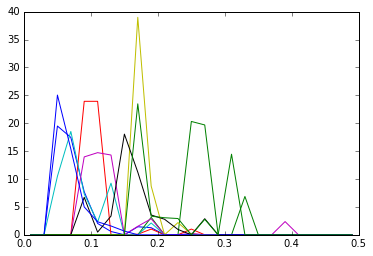

In [14]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [15]:
# add visualization of the sum

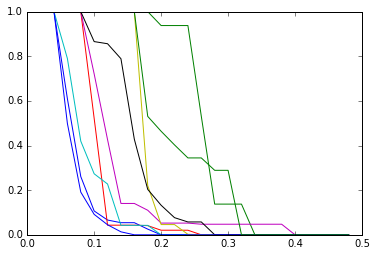

In [16]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

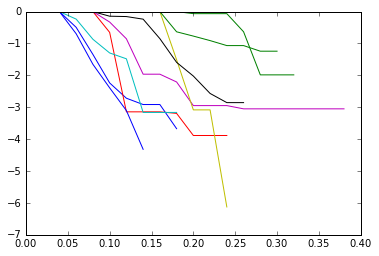

In [17]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

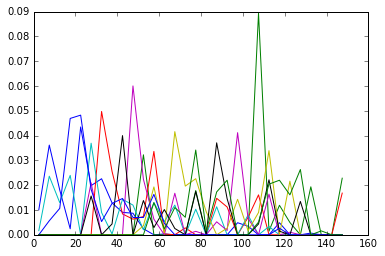

In [18]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

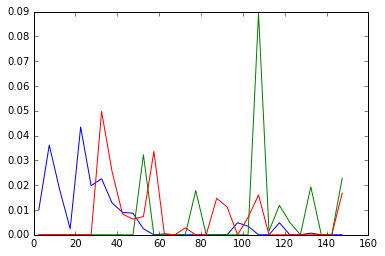

In [19]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [20]:
scheme = storage.schemes[0]

In [21]:
scheme.move_summary(storage)

ms_outer_shooting ran 5.65723793677% of the cycles with acceptance 23/34 (0.676470588235)
repex ran 21.1314475874% of the cycles with acceptance 46/127 (0.362204724409)
shooting ran 48.4193011647% of the cycles with acceptance 196/291 (0.6735395189)
minus ran 3.49417637271% of the cycles with acceptance 21/21 (1.0)
pathreversal ran 21.1314475874% of the cycles with acceptance 107/127 (0.842519685039)


In [22]:
scheme.move_summary(storage, 'shooting')

OneWayShootingMover I'face 0 ran 7.98668885191% of the cycles with acceptance 37/48 (0.770833333333)
OneWayShootingMover I'face 2 ran 6.48918469218% of the cycles with acceptance 19/39 (0.487179487179)
OneWayShootingMover I'face 2 ran 4.32612312812% of the cycles with acceptance 15/26 (0.576923076923)
OneWayShootingMover I'face 0 ran 4.99168053245% of the cycles with acceptance 29/30 (0.966666666667)
OneWayShootingMover I'face 2 ran 5.49084858569% of the cycles with acceptance 24/33 (0.727272727273)
OneWayShootingMover I'face 1 ran 4.15973377704% of the cycles with acceptance 16/25 (0.64)
OneWayShootingMover I'face 0 ran 4.32612312812% of the cycles with acceptance 23/26 (0.884615384615)
OneWayShootingMover I'face 1 ran 5.15806988353% of the cycles with acceptance 18/31 (0.58064516129)
OneWayShootingMover I'face 1 ran 5.49084858569% of the cycles with acceptance 15/33 (0.454545454545)


In [23]:
for mover in scheme.movers['shooting']:
    print mover, scheme.choice_probability[mover]*100

OneWayShootingMover I'face 0 4.97512437811
OneWayShootingMover I'face 1 4.97512437811
OneWayShootingMover I'face 2 4.97512437811
OneWayShootingMover I'face 0 4.97512437811
OneWayShootingMover I'face 1 4.97512437811
OneWayShootingMover I'face 2 4.97512437811
OneWayShootingMover I'face 0 4.97512437811
OneWayShootingMover I'face 1 4.97512437811
OneWayShootingMover I'face 2 4.97512437811


In [24]:
scheme.move_summary(storage, 'minus')

Minus ran 1.16472545757% of the cycles with acceptance 7/7 (1.0)
Minus ran 1.33111480865% of the cycles with acceptance 8/8 (1.0)
Minus ran 0.998336106489% of the cycles with acceptance 6/6 (1.0)


In [25]:
for mover in scheme.movers['minus']:
    print mover, scheme.choice_probability[mover]*100, '%'

Minus 0.995024875622 %
Minus 0.995024875622 %
Minus 0.995024875622 %


In [26]:
scheme.move_summary(storage, 'repex')

ReplicaExchange ran 1.66389351082% of the cycles with acceptance 5/10 (0.5)
ReplicaExchange ran 2.16306156406% of the cycles with acceptance 8/13 (0.615384615385)
ReplicaExchange ran 2.82861896839% of the cycles with acceptance 4/17 (0.235294117647)
ReplicaExchange ran 1.66389351082% of the cycles with acceptance 0/10 (0.0)
ReplicaExchange ran 4.32612312812% of the cycles with acceptance 8/26 (0.307692307692)
ReplicaExchange ran 0.665557404326% of the cycles with acceptance 2/4 (0.5)
ReplicaExchange ran 1.99667221298% of the cycles with acceptance 2/12 (0.166666666667)
ReplicaExchange ran 2.6622296173% of the cycles with acceptance 13/16 (0.8125)
ReplicaExchange ran 3.16139767055% of the cycles with acceptance 4/19 (0.210526315789)


In [27]:
for mover in scheme.movers['repex']:
    print mover, scheme.choice_probability[mover]*100, '%'

ReplicaExchange 2.48756218905 %
ReplicaExchange 2.48756218905 %
ReplicaExchange 2.48756218905 %
ReplicaExchange 2.48756218905 %
ReplicaExchange 2.48756218905 %
ReplicaExchange 2.48756218905 %
ReplicaExchange 2.48756218905 %
ReplicaExchange 2.48756218905 %
ReplicaExchange 2.48756218905 %


In [28]:
scheme.move_summary(storage, 'pathreversal')

PathReversal ran 2.99500831947% of the cycles with acceptance 18/18 (1.0)
PathReversal ran 1.8302828619% of the cycles with acceptance 10/11 (0.909090909091)
PathReversal ran 2.49584026622% of the cycles with acceptance 5/15 (0.333333333333)
PathReversal ran 1.8302828619% of the cycles with acceptance 8/11 (0.727272727273)
PathReversal ran 1.8302828619% of the cycles with acceptance 11/11 (1.0)
PathReversal ran 1.99667221298% of the cycles with acceptance 8/12 (0.666666666667)
PathReversal ran 1.8302828619% of the cycles with acceptance 10/11 (0.909090909091)
PathReversal ran 2.16306156406% of the cycles with acceptance 13/13 (1.0)
PathReversal ran 2.32945091514% of the cycles with acceptance 13/14 (0.928571428571)
PathReversal ran 1.8302828619% of the cycles with acceptance 11/11 (1.0)


In [29]:
for mover in scheme.movers['pathreversal']:
    print mover, scheme.choice_probability[mover]*100, '%'

PathReversal 2.48756218905 %
PathReversal 2.48756218905 %
PathReversal 2.48756218905 %
PathReversal 2.48756218905 %
PathReversal 2.48756218905 %
PathReversal 2.48756218905 %
PathReversal 2.48756218905 %
PathReversal 2.48756218905 %
PathReversal 2.48756218905 %
PathReversal 2.48756218905 %


### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [30]:
repx_net = paths.ReplicaNetwork(storage=storage)

#### Replica exchange mixing matrix

In [31]:
repx_net.mixing_matrix()

,2,0,6,-2,-3,7,8,4,9,5,1,3,-1
2,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.027027,0.000000,0.033784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.033784,0.000000,0.047297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-2,0.000000,0.000000,0.047297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.054054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.054054,0.000000,0.013514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000,0.087838,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087838,0.000000,0.054054,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054054,0.000000,0.013514,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000,0.054054,0.000000,0.000000


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

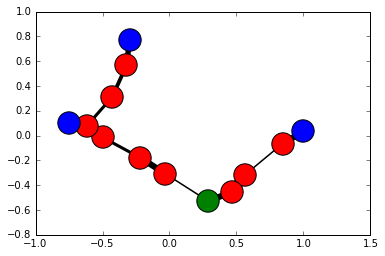

In [32]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [33]:
import openpathsampling.visualize as visualizations
reload(visualizations)
from IPython.display import SVG

history = visualizations.ReplicaHistoryTree(
    storage=storage,
    steps=storage.steps[0:200],
    replica=1
)

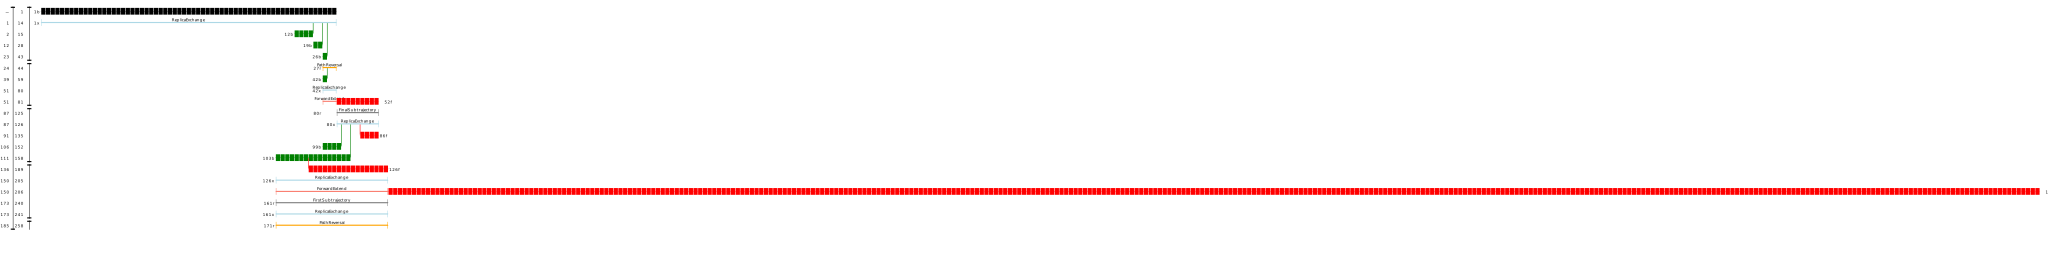

In [34]:
history.view.zoom = 1.0
history.view.scale_y = 24
history.view.scale_x = 10
history.view.font_size = 0.35
history.view.horizontal_gap = 0.05

SVG(history.view.to_svg())

In [35]:
decorrelated = history.decorrelated_trajectories
print "We have " + str(len(decorrelated)) + " decorrelated trajectories."

We have 5 decorrelated trajectories.


### Visualizing trajectories

In [36]:
from toy_plot_helpers import ToyPlot
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(storage.engines[0].pes)

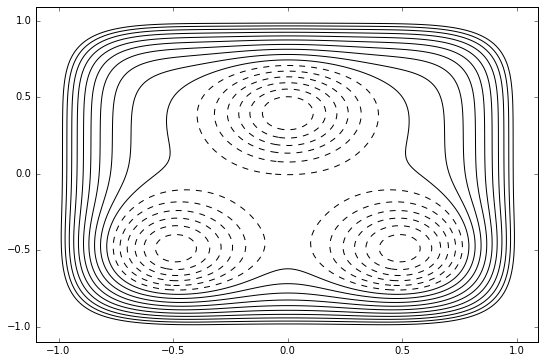

In [37]:
xval = paths.CV_Function("xval", lambda snap : snap.xyz[0][0])
yval = paths.CV_Function("yval", lambda snap : snap.xyz[0][1])
vis = paths.LiveVisualization(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
vis.background = background.plot()

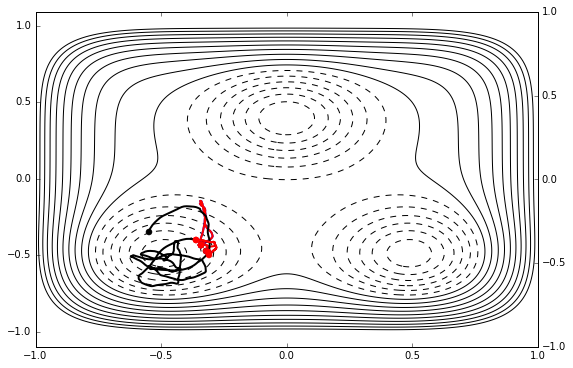

In [38]:
vis.draw_samples(history.trial_samples)

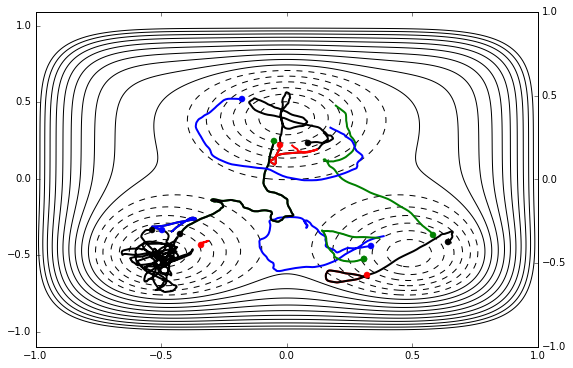

In [39]:
#! skip
# The skip directive tells our test runner not to run this cell
import time
max_step = 10
for step in storage.steps[0:max_step]:
    vis.draw_ipynb(step)
    time.sleep(0.1)

## Histogramming data (TODO)